# Drizzle 1: drizzle setup

Exercise the drizzle core algorithm to find the correct parameters to use in this project.

For now, we pay no attention to the fact the images are RGB Bayer-coded. All pixels are treated equally. A subsequent notebook will handle the gory details of 3-color drizzling.

In [1]:
# %matplotlib notebook

import os

import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from astropy.io import fits
from drizzle import cdrizzle
import rawpy

from datapath import DATA

## Basic drizze call

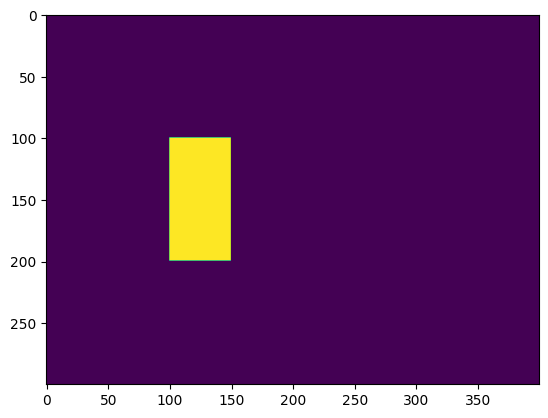

In [2]:
# simple test image - make it non-square so as to test the pixmap shaping algorithm
sizey = 300
sizex = 400
data = np.zeros((sizey, sizex), dtype='float32')
weights = np.ones((sizey, sizex), dtype='float32')

# image made of zeros, except for a rectangular area with ones
data[100:200, 100:150] = 1

# plt.imshow(data[90:110,90:110], vmin=0, vmax=1)
plt.imshow(data, vmin=0, vmax=1)

In [3]:
# pixmap is built following the "recipe" in the `drizzle.calc_pixmap` function
idxmap = np.indices((sizex, sizey), dtype='float64') # note the swapping of X and Y axis...

# move 100.3 in X and 50.5 in Y
idxmap[0] += 100.3 
idxmap[1] += 50.5 

idxmap = idxmap.transpose()
idxmap = idxmap.reshape(sizex * sizey, 2)
pixmap = idxmap.reshape(sizey, sizex, 2)

In [4]:
# allocate output arrays
output_data = np.zeros((sizey, sizex), dtype='float32')
output_counts = np.zeros((sizey,sizex), dtype='float32')
output_context = np.zeros((sizey, sizex), dtype='int32')

# call C core drizzle algorithm
cdrizzle.tdriz(data, weights, pixmap, output_data, output_counts, output_context)

('Callable C-based DRIZZLE Version 1.12 (28th June 2018)', 45000, 48)

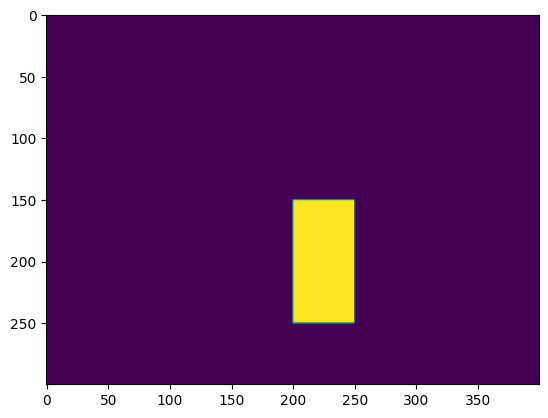

In [5]:
# plt.imshow(output_data[140:160,140:160], vmin=0, vmax=1)
plt.imshow(output_data, vmin=0, vmax=1)

The output array above shows fractional pixel coverage effects at the object edges, compatible with the offsets added to the pixmap.

## Apply drizzle to real image

In [6]:
# reference image used in the Offsets_X scripts. Offsets are defined against this image.
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03770.ARW')
raw = rawpy.imread(fname)
reference_imarray = raw.raw_image_visible.astype(float)

In [7]:
# last image in sequence. This should have the largest offsets.
fname = os.path.join(DATA,'astrophotography_data/MilkyWayPrettyBoy/12800/light/DSC03829.ARW')
raw = rawpy.imread(fname)
imarray = raw.raw_image_visible.astype(float)

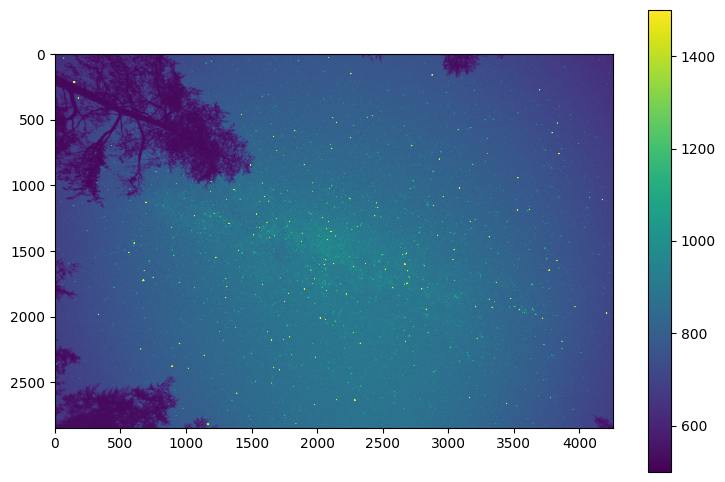

In [8]:
plt.figure(figsize=[9, 6])
plt.imshow(reference_imarray, vmin=500, vmax=1500)
plt.colorbar()

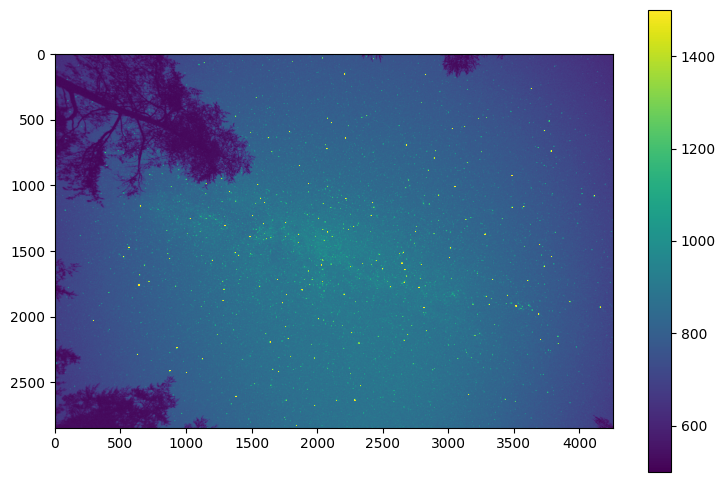

In [9]:
plt.figure(figsize=[9, 6])
plt.imshow(imarray, vmin=500, vmax=1500)
plt.colorbar()

In [10]:
# define slice for displaying a small subset of images.
aslice = np.index_exp[1100:1290,1900:2100]
# aslice = np.index_exp[1000:1500,800:1300]

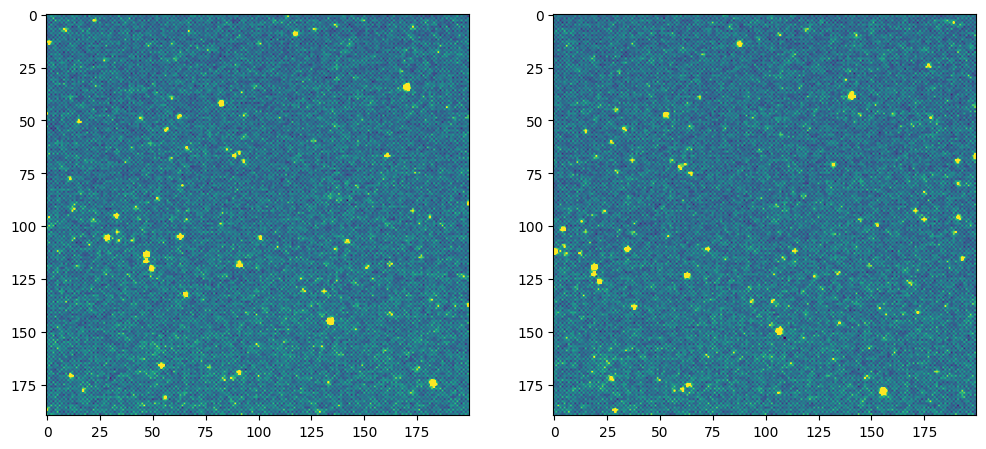

In [11]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(imarray[aslice], vmin=500, vmax=1500)

In [12]:
# pixmap comes from offsets file
fname_offsets = fname.replace('ARW', 'offsets.fits')

f = fits.open(fname_offsets)
offsets_x = f[1].data
offsets_y = f[2].data
f.close()

In [13]:
# pixmap
idxmap = np.indices((imarray.shape[1], imarray.shape[0]), dtype='float64')

# here we add the offsets derived by the Offsets_X set of scripts.
idxmap[0] -= offsets_x.transpose()
idxmap[1] -= offsets_y.transpose()

idxmap = idxmap.transpose()
idxmap = idxmap.reshape(imarray.shape[1] * imarray.shape[0], 2)
pixmap = idxmap.reshape(imarray.shape[0], imarray.shape[1], 2)

# weigths
weights = np.ones(imarray.shape, dtype='float32')

# output arrays
output_data = np.zeros(imarray.shape, dtype='float32')
output_counts = np.zeros(imarray.shape, dtype='float32')
output_context = np.zeros(imarray.shape, dtype='int32')

In [14]:
# TODO: cdrizzle will barf when presented with an input array directly derived from 
# the rawpy package. No numpy-based copy operation could fix that. However, copying
# pixel-by-pixel in ths very non-nupy-esque (and *SLOW*) loop fixed the problem. 
imarray_f = np.zeros(imarray.shape, dtype='float32')

for i in list(range(imarray.shape[1])):
    for j in list(range(imarray.shape[0])):
        imarray_f[j][i] = imarray[j][i]

In [15]:
# call C core drizzle algorithm
cdrizzle.tdriz(imarray_f, weights, pixmap, output_data, output_counts, output_context)

('Callable C-based DRIZZLE Version 1.12 (28th June 2018)', 212078, 0)

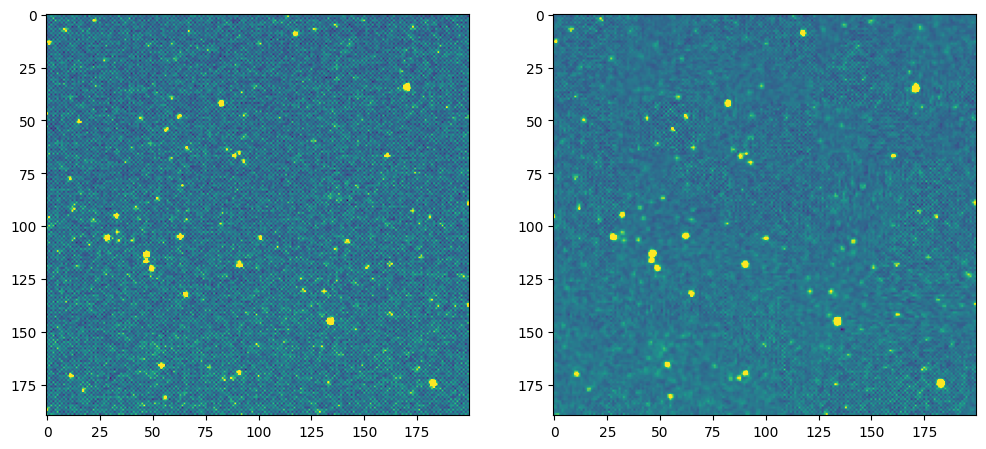

In [16]:
fig = plt.figure(figsize=[12, 6])
ax = fig.add_subplot(1, 2, 1)
plt.imshow(reference_imarray[aslice], vmin=500, vmax=1500)
# plt.imshow(imarray[aslice], vmin=500, vmax=1500)
ax1 = fig.add_subplot(1, 2, 2, sharex=ax, sharey=ax)
plt.imshow(output_data[aslice], vmin=500, vmax=1500)